In [1]:
#create linear regressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Load and partition data
df = pd.read_csv("../scans/scan7/scan7Clean.csv.zip")
# select nfp
nfp=3
df = df[df['nfp'] == nfp]
y = df.loc[:, ['rc1', 'zs1', 'eta']]

X = df.loc[:, ['RotTrans', 'axLenght', 'max_elong']]


# Split training and testing sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, train_size=0.9,
                     random_state=0)

# Split training and validationsets
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_train, y_train, test_size=0.1, train_size=0.9,
                     random_state=0)

#scale
X_scaler = preprocessing.StandardScaler()
#X_scaler = preprocessing.RobustScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled =  X_scaler.transform(X_validation)

y_scaler = preprocessing.StandardScaler()
#y_scaler = preprocessing.RobustScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
y_validation_scaled =  y_scaler.transform(y_validation)


out={
    "index":[],
    "R2_validation":[]
}


polyReg = make_pipeline(preprocessing.PolynomialFeatures(degree=12), LinearRegression())

polyReg.fit(X_train_scaled, y_train_scaled)

test_predictions = polyReg.predict(X_test_scaled)
validation_predictions = polyReg.predict(X_validation_scaled)


print("test stats:")
print("r2: ", r2_score(y_test_scaled, test_predictions))
print("mse: ", mean_squared_error(y_test_scaled, test_predictions))
print("\nvalidation stats:")
print("r2: ", r2_score(y_validation_scaled, validation_predictions))
print("mse: ", mean_squared_error(y_validation_scaled, validation_predictions))

test stats:
r2:  0.9747535404316953
mse:  0.025303484924459333

validation stats:
r2:  0.9730563094302104
mse:  0.026299425859255477


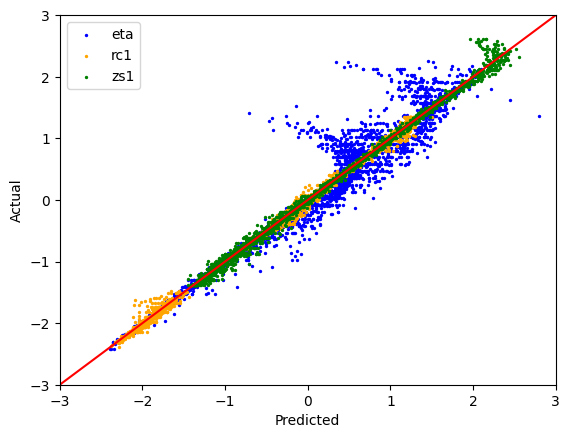

In [2]:
#plot linear regressor
fig, ax = plt.subplots()

ax.scatter(test_predictions[:,2],y_test_scaled[:,2], c="blue", label="eta",s=2)
ax.scatter(test_predictions[:,0],y_test_scaled[:,0], c="orange", label="rc1", s=2)
ax.scatter(test_predictions[:,1],y_test_scaled[:,1], c="green", label="zs1", s=2)

plt.axline([0, 0], [1, 1], color='red')
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.legend()

In [3]:
#real error linear reg
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from qsc import Qsc
Y_LR = polyReg.predict(X_test_scaled)
Y_LR_unscaled = y_scaler.inverse_transform(Y_LR)

out = {
    "RotTrans" : [],
    "axLenght" : [],
    "max_elong" : [],
}
OutlierList = []
for i in range(len(Y_LR_unscaled)):
    rc1=Y_LR_unscaled[i][0]
    zs1=Y_LR_unscaled[i][1]
    eta=Y_LR_unscaled[i][2]
    stel = Qsc(rc=[1,rc1],zs=[0,zs1],nfp=nfp,etabar=eta)
    out["RotTrans"].append(stel.iota)
    out["axLenght"].append(stel.axis_length / 2. / np.pi)
    out["max_elong"].append(stel.max_elongation)
    if stel.max_elongation > 15:
        print(i, " max elongation >15")
        OutlierList.append(i)

predictedX=pd.DataFrame(out)
print(df)

428  max elongation >15
519  max elongation >15
1555  max elongation >15
        axLenght  RotTrans  nfp   heli       rc1       zs1       eta  \
7023    1.039983  0.202394    3  False  0.012245 -0.134694 -0.864286   
7024    1.039983  0.203886    3  False  0.012245 -0.134694 -0.803265   
7025    1.039983  0.200779    3  False  0.012245 -0.134694 -0.742245   
7026    1.043558  0.205021    3  False  0.012245 -0.140816 -0.864286   
7027    1.043558  0.207371    3  False  0.012245 -0.140816 -0.803265   
...          ...       ...  ...    ...       ...       ...       ...   
196561  1.269033  1.368953    3   True  0.213627 -0.297710 -1.515974   
196566  1.132677  1.438993    3   True  0.188479 -0.162969 -1.909999   
196568  1.157310  1.115720    3   True  0.157538 -0.223832 -1.300393   
196570  1.312247  1.506512    3   True  0.296063 -0.262473 -1.324685   
196576  1.295229  2.220743    3   True  0.287696 -0.253549 -2.936351   

        max_elong    LgradB    min_R0  
7023     7.863422  0.3

non normalized
test stats:
r2:  0.17195741530050598
mse:  2.380355367205237
mse Rotational Transform:  0.002236755002361681
mse Axis Length:  7.852540636651067e-08
mse Max Elongation:  7.138829268087943

normalized:
test stats:
r2:  0.17195741530050568
mse:  0.8098766634412207
mse Rotational Transform:  0.009797668707352655
mse Axis Length:  8.721988482420674e-06
mse Max Elongation:  2.419823599627827


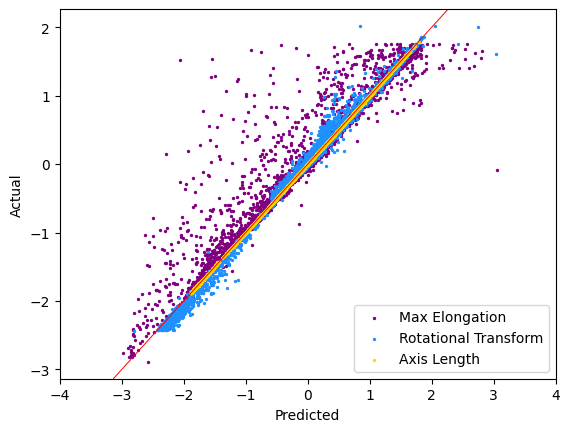

In [11]:
#plot linear regressor real error
print("non normalized")
print("test stats:")
print("r2: ", r2_score(X_test, predictedX))
print("mse: ", mean_squared_error(X_test, predictedX))
print("mse Rotational Transform: ", mean_squared_error(X_test["RotTrans"], predictedX["RotTrans"]))
print("mse Axis Length: ", mean_squared_error(X_test["axLenght"], predictedX["axLenght"]))
print("mse Max Elongation: ", mean_squared_error(X_test["max_elong"], predictedX["max_elong"]))


print("\nnormalized:")
predictedX_scaled = X_scaler.transform(predictedX)
print("test stats:")
print("r2: ", r2_score(X_test_scaled, predictedX_scaled))
print("mse: ", mean_squared_error(X_test_scaled, predictedX_scaled))
print("mse Rotational Transform: ", mean_squared_error(X_test_scaled[:,0], predictedX_scaled[:,0]))
print("mse Axis Length: ", mean_squared_error(X_test_scaled[:,1], predictedX_scaled[:,1]))
print("mse Max Elongation: ", mean_squared_error(X_test_scaled[:,2], predictedX_scaled[:,2]))


fig, ax = plt.subplots()
ax.scatter(predictedX_scaled[:,2],X_test_scaled[:,2], c="purple", label="Max Elongation", s=2)
ax.scatter(predictedX_scaled[:,0],X_test_scaled[:,0], c="dodgerblue", label="Rotational Transform",s=2)
ax.scatter(predictedX_scaled[:,1],X_test_scaled[:,1], c="gold", label="Axis Length", s=2)

plt.axline([0, 0], [1, 1], color='red', lw=0.7)
#plt.ylim(-3, 3)
plt.xlim(-4, 4)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.legend()

In [5]:
#real error no outlier
print("outliers index:", OutlierList)
print("non normalized without outliers")
X_testNoOutlier = X_test.copy()
X_testNoOutlier.reset_index(inplace=True)
predictedXNoOutlier = predictedX.drop(OutlierList)
X_testNoOutlier = X_testNoOutlier.drop(OutlierList)
print("mse Max Elongation: ", mean_squared_error(X_testNoOutlier["max_elong"], predictedXNoOutlier["max_elong"]))


print("normalized without outliers:")
X_test_scaledNoOutlier = X_test_scaled
predictedX_scaledNoOutlier = X_scaler.transform(predictedXNoOutlier)
X_test_scaledNoOutlier = X_test_scaled
X_test_scaledNoOutlier=np.delete(X_test_scaledNoOutlier,OutlierList,axis=0)
print("mse Max Elongation: ", mean_squared_error(X_test_scaledNoOutlier[:,2], predictedX_scaledNoOutlier[:,2]))


outliers index: [428, 519, 1555]
non normalized without outliers
mse Max Elongation:  0.3887737907223536
normalized without outliers:
mse Max Elongation:  0.13178127090279806
